# COSMOS master catalogue
## Convert COSMOS2016 to help format for comparison and homogeniety

This catalogue comes from `dmu1_COSMOS2015`. At present we will only cross match the ids into the HELP masterlist. to go into the cross id table. This will allow comparisons for our internal testing as well as allow users of the COSMOS catalogue to get other fluxes and HELP products.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100)
This notebook was executed on: 
2019-04-02 16:22:51.714272


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag

/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/opt/pyenv/versions/3.7.2/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cosmos_ra"
DEC_COL = "cosmos_dec"

## I - Column selection

In [4]:
bands = OrderedDict({
    'ks': 'vista_ks',
    'y': 'vista_y',
    'h': 'vista_h',
    'j': 'vista_j',

    #CFHT Megacam
    'u': 'megacam_u',
    #SUBARU Suprime
    'b': 'suprime_b',
    'v': 'suprime_v',
    'ip': 'suprime_ip',
    'r': 'suprime_rc',
    'zp': 'suprime_zp',
    'zpp': 'suprime_zpp',
    'ia484': 'suprime_ia484',
    'ia527': 'suprime_ia527',
    'ia624': 'suprime_ia624',
    'ia679': 'suprime_ia679',
    'ia738': 'suprime_ia738',
    'ia767': 'suprime_ia767',
    'ib427': 'suprime_ib427',
    'ib464': 'suprime_ib464',
    'ib505': 'suprime_ib505',
    'ib574': 'suprime_ib574',
    'ib709': 'suprime_ib709',
    'ib827': 'suprime_ib827',
    'nb711': 'suprime_nb711',
    'nb816': 'suprime_nb816',
    #CFHT WIRCAM
    'hw': 'wircam_h',
    'ksw': 'wircam_ks',
    #SUBARU HSC
    'yhsc': 'suprime_y',
    #Spitzer IRAC
    'splash_1': 'irac_i1', #'irac_i1'???
    'splash_2': 'irac_i2', # #irac_i2
    'splash_3': 'irac_i3', # #irac_i1
    'splash_4': 'irac_i4', # #irac_i4
})

In [5]:
imported_columns = OrderedDict({
    'help_id': 'help_id',
    'id': 'cosmos_id',
    'alpha_j2000': 'cosmos_ra',
    'delta_j2000': 'cosmos_dec',
    'class': 'cosmos_stellarity',
})

for band in list(bands):
    if 'splash' not in band:
        imported_columns.update({band + '_mag_auto': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_magerr_auto': 'merr_cosmos-' + bands[band]})
        imported_columns.update({band + '_flux_aper2': 'f_ap_cosmos-' + bands[band]})
        imported_columns.update({band + '_fluxerr_aper2': 'ferr_ap_cosmos-' + bands[band]})
    elif 'splash' in band:
        imported_columns.update({band + '_flux': 'f_cosmos-' + bands[band]})
        imported_columns.update({band + '_flux_err': 'ferr_cosmos-' + bands[band]})
        imported_columns.update({band + '_mag': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_magerr': 'merr_cosmos-' + bands[band]})        
        


In [6]:

catalogue = Table.read("../../dmu0/dmu0_COSMOS2015/data/COSMOS2015-HELP_selected_20160613.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2015 #Various epochs

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    #print(col)
    if 'irac' in col:
        if col.startswith('f_'):
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
            mask = ( (catalogue[col] < -90.)
                   | (catalogue[col.replace('f_', 'ferr_')] < -90.)
                   )
            catalogue[col][mask] = np.nan
            catalogue[col.replace('f_', 'ferr_')][mask] = np.nan
        if col.startswith('m_'):
           
            mask = ( (catalogue[col] < -90.)
                   | (catalogue[col.replace('m_', 'merr_')] < -90.)
                   )
            catalogue[col][mask] = np.nan
            catalogue[col.replace('m_', 'merr_')][mask] = np.nan
        continue
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        
        mask = (catalogue[col] > 90.) | (catalogue[col] < 0.)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask]  = np.nan     
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        mask = (np.isclose(catalogue[col] , -99.9) )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan 
        
        mag, error = flux_to_mag(np.array(catalogue[col])* 1.e-6, np.array(catalogue[errcol])* 1.e-6)
        # Mags added
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:77: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/hersc

In [8]:
catalogue[:10].show_in_notebook()

idx,help_id,cosmos_id,cosmos_ra,cosmos_dec,cosmos_stellarity,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_ap_cosmos-vista_ks,ferr_ap_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_ap_cosmos-vista_y,ferr_ap_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_ap_cosmos-vista_h,ferr_ap_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_ap_cosmos-vista_j,ferr_ap_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_ap_cosmos-megacam_u,ferr_ap_cosmos-megacam_u,m_cosmos-suprime_b,merr_cosmos-suprime_b,f_ap_cosmos-suprime_b,ferr_ap_cosmos-suprime_b,m_cosmos-suprime_v,merr_cosmos-suprime_v,f_ap_cosmos-suprime_v,ferr_ap_cosmos-suprime_v,m_cosmos-suprime_ip,merr_cosmos-suprime_ip,f_ap_cosmos-suprime_ip,ferr_ap_cosmos-suprime_ip,m_cosmos-suprime_rc,merr_cosmos-suprime_rc,f_ap_cosmos-suprime_rc,ferr_ap_cosmos-suprime_rc,m_cosmos-suprime_zp,merr_cosmos-suprime_zp,f_ap_cosmos-suprime_zp,ferr_ap_cosmos-suprime_zp,m_cosmos-suprime_zpp,merr_cosmos-suprime_zpp,f_ap_cosmos-suprime_zpp,ferr_ap_cosmos-suprime_zpp,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_ap_cosmos-suprime_ia484,ferr_ap_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_ap_cosmos-suprime_ia527,ferr_ap_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_ap_cosmos-suprime_ia624,ferr_ap_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_ap_cosmos-suprime_ia679,ferr_ap_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_ap_cosmos-suprime_ia738,ferr_ap_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_ap_cosmos-suprime_ia767,ferr_ap_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_ap_cosmos-suprime_ib427,ferr_ap_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_ap_cosmos-suprime_ib464,ferr_ap_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_ap_cosmos-suprime_ib505,ferr_ap_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_ap_cosmos-suprime_ib574,ferr_ap_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_ap_cosmos-suprime_ib709,ferr_ap_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_ap_cosmos-suprime_ib827,ferr_ap_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_ap_cosmos-suprime_nb711,ferr_ap_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_ap_cosmos-suprime_nb816,ferr_ap_cosmos-suprime_nb816,m_cosmos-wircam_h,merr_cosmos-wircam_h,f_ap_cosmos-wircam_h,ferr_ap_cosmos-wircam_h,m_cosmos-wircam_ks,merr_cosmos-wircam_ks,f_ap_cosmos-wircam_ks,ferr_ap_cosmos-wircam_ks,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_ap_cosmos-suprime_y,ferr_ap_cosmos-suprime_y,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i4,ferr_cosmos-irac_i4,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-vista_ks,ferr_cosmos-vista_ks,flag_cosmos-vista_ks,m_ap_cosmos-vista_ks,merr_ap_cosmos-vista_ks,f_cosmos-vista_y,ferr_cosmos-vista_y,flag_cosmos-vista_y,m_ap_cosmos-vista_y,merr_ap_cosmos-vista_y,f_cosmos-vista_h,ferr_cosmos-vista_h,flag_cosmos-vista_h,m_ap_cosmos-vista_h,merr_ap_cosmos-vista_h,f_cosmos-vista_j,ferr_cosmos-vista_j,flag_cosmos-vista_j,m_ap_cosmos-vista_j,merr_ap_cosmos-vista_j,f_cosmos-megacam_u,ferr_cosmos-megacam_u,flag_cosmos-megacam_u,m_ap_cosmos-megacam_u,merr_ap_cosmos-megacam_u,f_cosmos-suprime_b,ferr_cosmos-suprime_b,flag_cosmos-suprime_b,m_ap_cosmos-suprime_b,merr_ap_cosmos-suprime_b,f_cosmos-suprime_v,ferr_cosmos-suprime_v,flag_cosmos-suprime_v,m_ap_cosmos-suprime_v,merr_ap_cosmos-suprime_v,f_cosmos-suprime_ip,ferr_cosmos-suprime_ip,flag_cosmos-suprime_ip,m_ap_cosmos-suprime_ip,merr_ap_cosmos-suprime_ip,f_cosmos-suprime_rc,ferr_cosmos-suprime_rc,flag_cosmos-suprime_rc,m_ap_cosmos-suprime_rc,merr_ap_cosmos-suprime_rc,f_

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = []
for f in list(bands):
    if 'splash' not in f:
        SORT_COLS += ['merr_ap_cosmos-' + bands[f]]


In [10]:
#SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 694478 sources.
The cleaned catalogue has 694478 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [11]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

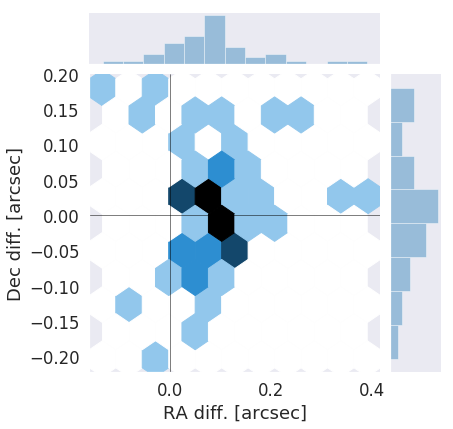

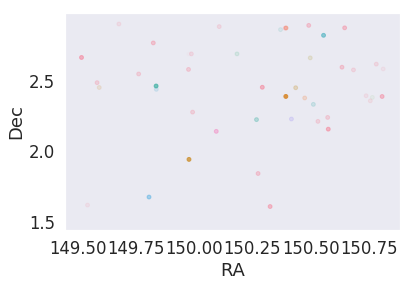

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [13]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07898549040419311 arcsec
Dec correction: -0.010563906203397977 arcsec


In [14]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

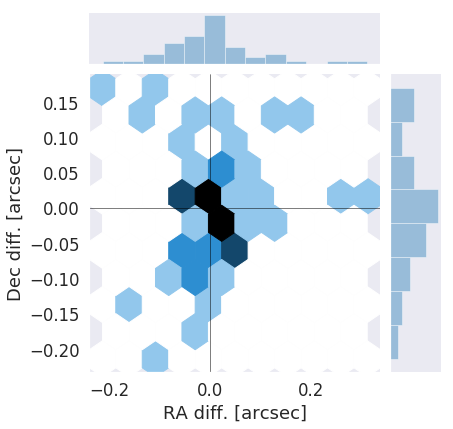

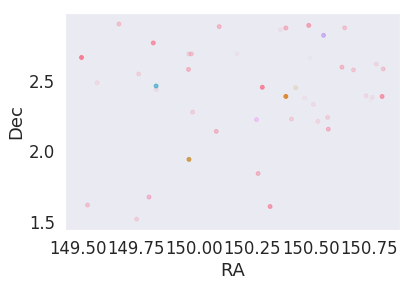

In [15]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [16]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [17]:
GAIA_FLAG_NAME = "cosmos_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

46 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [18]:
catalogue.write("{}/COSMOS2015_HELP.fits".format(OUT_DIR), overwrite=True)